# Prediction du PIB canadien avec des méthodes de *Deep Learning*

Ce *notebook* repose sur les références suivantes : 



*   [Time Series Analysis with Python](http://nmmarcelnv.pythonanywhere.com/blogs/timeseries)
*   [Time Series Prediction with LSTM Using PyTorch](https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb)
* [How to Develop Convolutional Neural Network Models for Time Series Forecasting](https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/)
* [[CNN]Time-series Forecasting with Pytorch](https://www.kaggle.com/hanjoonchoe/cnn-time-series-forecasting-with-pytorch)

## Téléchargement du jeu de données



In [1]:
!wget https://gitlab.com/JACQUOT_THOMAS/gdp_canada_lstm/-/raw/master/data/GDP_open_canada.csv

--2021-04-28 16:18:48--  https://gitlab.com/JACQUOT_THOMAS/gdp_canada_lstm/-/raw/master/data/GDP_open_canada.csv
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘GDP_open_canada.csv.3’

GDP_open_canada.csv     [   <=>              ]  54.11M   102MB/s    in 0.5s    

2021-04-28 16:19:14 (102 MB/s) - ‘GDP_open_canada.csv.3’ saved [56743639]



## *Packages* nécessaires à l'exécution du *notebook*

In [2]:
#Packages de base 
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import pandas as pd
#Packages econometrie
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 
#Packages pour les modèles de deep learning 
import torch
import gc
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader
#Packages pour le calcul des metriques 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
#Packages pour gestion des dates et du temps
from datetime import date
from dateutil.relativedelta import relativedelta
from tqdm import tqdm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Exploration des données 

Les données présentées ici correspondent au PIB en valeur de l'ensemble des industries canadiennes entre janvier 1997 et janvier 2021. Il s'agit donc d'une série temporelle mensuelle et univariée de 24 années consécutives. Les données sont exprimées en million de dollars et en prix constants de 2012. Elles sont également ajustées selon le nombre de jours ouvrables par années. 

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


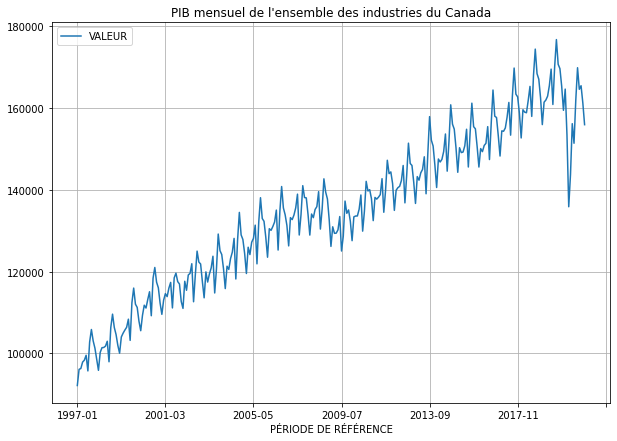

In [3]:
#Lecture et nettoyage du jeu de données 
gdp_canada = pd.read_csv("GDP_open_canada.csv", sep = ";")
gdp_canada = gdp_canada[gdp_canada["Système de classification des industries de l'Amérique du Nord (SCIAN)"]=="Ensemble des industries [T001]"]
gdp_canada = gdp_canada[gdp_canada["Désaisonnalisation"]=="Ajustées pour les jours ouvrables"]
#Affichage de la serie
gdp_canada.plot(x="PÉRIODE DE RÉFÉRENCE", y="VALEUR", figsize=(10,7))
plt.title("PIB mensuel de l'ensemble des industries du Canada")
plt.grid()
plt.show()

Ce premier aperçu de la série fait clairement apparaitre une tendance croissante ainsi qu'une saisonnalité mensuelle. Ce constat sera pris en compte lors des différentes modélisations à venir. Notons également que ce graphique fait nettement apparaitre les crises économiques de 2008(crise financière) et de 2020(crise du Covid).

## Un modèle économétrique de référence : SARIMA

Commençons par réaliser une modélisation classique de la série grâce à un modèle classique d'économétrie à savoir le modèle SARIMA. Ce modèle sera par la suite notre modèle de référence. 

### Stationarité de la série

Une première étape lors de la modélisation des séries temporelles en économétrie est la stationarisation. 

Dans la cellule suivante nous définisson le test de *Dickey-Fuller*. Son hypothèse nulle correpond à la proposition suivante : "la série n'est pas stationnaire". 

In [4]:
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [5]:
ts = pd.Series(data = gdp_canada['VALEUR'])
ts.index = pd.to_datetime(gdp_canada['PÉRIODE DE RÉFÉRENCE'], format = "%Y-%m")
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.734415
p-value                          0.413474
#Lags Used                      14.000000
Number of Observations Used    274.000000
Critical Value (1%)             -3.454444
Critical Value (5%)             -2.872147
Critical Value (10%)            -2.572422
dtype: float64


La *p-value* obtenu pour le test de *Dickey-Fuller* sur la série initiale est de 0.41. Autrement dit,on ne rejette pas l'hypothèse nulle au niveau de confiance 0,05. La série initiale n'est donc pas stationaire comme le laissait supposer le graphique précédent. 

Afin de stationariser la série, il convient de lui retirer sa tendance ainsi que sa saisonalité. 

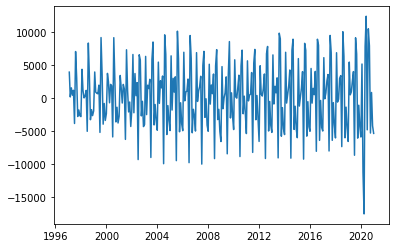

<Figure size 720x504 with 0 Axes>

In [6]:
#Retire la tendance 
nonseasonal_diff = ts.diff(periods=1)
plt.plot(nonseasonal_diff)
plt.figure(figsize=(10,7))
plt.show()

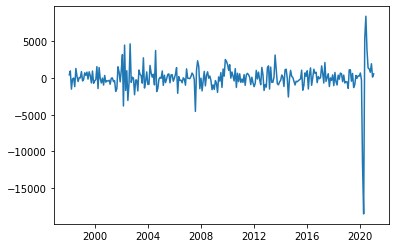

In [7]:
#Retire la saisonalité
seasonal_diff = nonseasonal_diff.diff(periods=12)
plt.plot(seasonal_diff)
plt.show()

In [8]:
test_stationarity(seasonal_diff.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                -1.147772e+01
p-value                        5.082800e-21
#Lags Used                     2.000000e+00
Number of Observations Used    2.730000e+02
Critical Value (1%)           -3.454533e+00
Critical Value (5%)           -2.872186e+00
Critical Value (10%)          -2.572443e+00
dtype: float64


Apres avoir enlevé la tendance et la saisonalité de la série nous obtenons enfin une série stationnaire comme le prouve le test de *Dickey-Fuller* ci-dessus. La *p-value* obtenue est largement inférieure à 0.05. On peut donc rejeter l'hypothèse nulle et afirmer que la série ainsi modifiée est staitionnaire. 

### Paramètres du modèle

Il convient ensuite de déterminer les paramètres $p$ et $q$ relatifs à la partie $AR$ (*Autoregressive*) et $MA$ (*Moving average*). Pour les identifier on utilise respectivement les autocorrelations partielles et les autocorrelations. 

In [9]:
lag_acf  = acf(seasonal_diff.dropna(inplace=False), nlags=24)
lag_pacf = pacf(seasonal_diff.dropna(inplace=False), nlags=24, method='ols')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


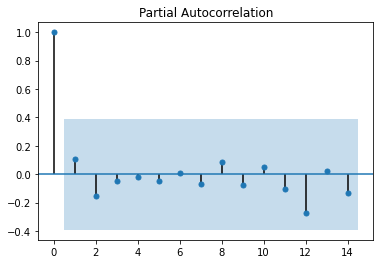

In [10]:
pacfplot=plot_pacf(lag_pacf)

D'après le graphique ci-dessus, il faudrait poser $p=0$ car l'autocorrelation partielle est non significative ensuite. 

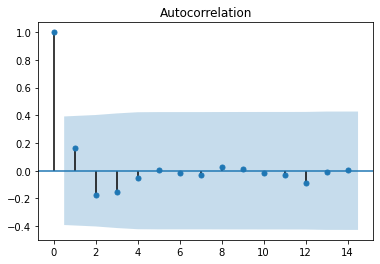

In [11]:
acfplot =plot_acf(lag_acf)

En se basant sur l'autocorrelation, il convient de supposer que $q=0$ car les autocorrelations sont non significatives pour tout $t>0$.

### Entrainement du modèle et prédictions

On sépare la série en un échantillon d'entrainement et un échantillon test. 

In [12]:
train_size = int(len(ts) * 0.67)
ts_train = ts[:train_size]
ts_test = ts[train_size:]
date_begin_train = ts.index[0]
date_end_train = ts.index[train_size-1]
date_begin_test = ts.index[train_size]
date_end_test = ts.index[-1]

Ensuite, on applique un $SARIMA(p,d,q)(P,D,Q,s)$. D'après ce qu'on a vu précedemment la saisonnalité est clairement $s=12$. A partir de la série différenciée ($d=1$) on a identifié que $p=0$ et $q=0$. Pour $P$ et $Q$, il est logique de les prendre égaux à 1. 

In [13]:
model = SARIMAX(ts_train, trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))
results_ARIMA = model.fit(disp=-1)  
results_ARIMA.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             VALEUR   No. Observations:                  193
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -1533.498
Date:                            Wed, 28 Apr 2021   AIC                           3072.997
Time:                                    16:19:19   BIC                           3082.575
Sample:                                01-01-1997   HQIC                          3076.880
                                     - 01-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.4656      0.729      0.639      0.523      -0.963       1.894
ma.S.L12      -0.5031      0.711     -0.708      0.479      -1.896       0.890
sigma2      1.464e+06   1.02e+05     14.329      0.000    1.26e+06    1.66e+06
===================================================================================
Ljung-Box (Q):                       42.30   Jarque-Bera (JB):                63.88
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                             0.36
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
#Stockage des valeurs apprises sur le train et prédites sur le test
df = pd.DataFrame(ts)
s1 = results_ARIMA.fittedvalues
s2 = results_ARIMA.predict(start = date_begin_test, end= date_end_test, dynamic= True)
df = pd.DataFrame(ts)
df['forecast'] = pd.concat([s1,s2]).values
df = df['1998-02':'2020'] #on enleve les premières valeurs pour lesquelles l'historique est trop court et on ne prend pas en compte 2021

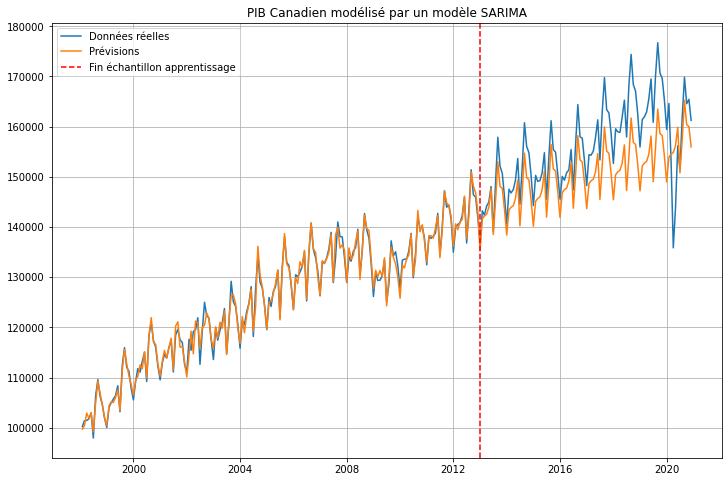

In [15]:
#Affichage des résultats
plt.figure(figsize=(12,8))
plt.plot(df['VALEUR'], label = 'Données réelles')
plt.plot(df['forecast'], label = 'Prévisions')
plt.axvline(x=date_end_train, c='r', linestyle='--', label = 'Fin échantillon apprentissage')
plt.grid()
plt.legend()
plt.title('PIB Canadien modélisé par un modèle SARIMA')
plt.show()

Le modèle SARIMA obtenu ci-dessus est reltivement satisfaisant. Au début de la série, il y a deux gros pics qui sont prinicpalement dus à l'absence d'hsitorique. Il convient donc de regarder à partir de fev-98 (après avoir laissé passer un an). Sur la partie train les predictions sont correctes. Sur la partie test en revanche le décalage entre les deux séries ne cesse de croitre. Le modèle ne capte pas, à long terme, l'augmentation de la tendance croissante. Evidemment il ne peux pas prédire non plus les crises exogènes comme celle du covid. 

In [43]:
#Test 
print("Test scores")
print("-----------") 
print('rmse : {:.2f}'.format(np.sqrt(mean_squared_error(df["VALEUR"][date_begin_test:] , df["forecast"][date_begin_test:] ))))
print('correlation : {:.2f}%'.format(np.corrcoef(df["VALEUR"][date_begin_test:], df["forecast"][date_begin_test:])[0,1]*100))
print('r2 : {:.3f}'.format(r2_score(df["VALEUR"][date_begin_test:], df["forecast"][date_begin_test:])))
print('\n')
#Test à deux ans 
print("Test scores (à deux ans)")
print("-------------------------") 
print('rmse : {:.2f}'.format(np.sqrt(mean_squared_error(df["VALEUR"][date_begin_test : date_begin_test + relativedelta(years=2)] , df["forecast"][date_begin_test : date_begin_test + relativedelta(years=2)]))))
print('correlation : {:.2f}%'.format(np.corrcoef(df["VALEUR"][date_begin_test : date_begin_test + relativedelta(years=2)], df["forecast"][date_begin_test : date_begin_test + relativedelta(years=2)])[0,1]*100))
print('r2 : {:.3f}'.format(r2_score(df["VALEUR"][date_begin_test : date_begin_test + relativedelta(years=2)], df["forecast"][date_begin_test : date_begin_test + relativedelta(years=2)])))
print('\n')
#Train  
print("Train scores")
print("------------") 
print('rmse : {:.2f}'.format(np.sqrt(mean_squared_error(df["VALEUR"][:date_end_train], df["forecast"][:date_end_train]))))
print('correlation : {:.2f}%'.format(np.corrcoef(df["VALEUR"][:date_end_train], df["forecast"][:date_end_train])[0,1]*100))
print('r2 : {:.3f}'.format(r2_score(df["VALEUR"][:date_end_train], df["forecast"][:date_end_train])))
print('\n')
#Train + Test 
print("Train + Test scores")
print("-------------------") 
print('rmse : {:.2f}'.format(np.sqrt(mean_squared_error(df["VALEUR"], df["forecast"]))))
print('correlation : {:.2f}%'.format(np.corrcoef(df["VALEUR"], df["forecast"])[0,1]*100))
print('r2 : {:.3f}'.format(r2_score(df["VALEUR"], df["forecast"])))
print('\n')

Test scores
-----------
rmse : 7263.13
correlation : 83.90%
r2 : 0.259


Test scores (à deux ans)
-------------------------
rmse : 3813.59
correlation : 96.41%
r2 : 0.475


Train scores
------------
rmse : 1212.53
correlation : 99.50%
r2 : 0.990


Train + Test scores
-------------------
rmse : 4380.19
correlation : 98.27%
r2 : 0.942




Les scores calculés ci-dessus semblent satisfaisant mais nous ne pouvons pas vraiment les commenter en l'absence de modèle de comparaison. Implémentons donc une approche par LSTM afin de voir si nous obtenons de meilleurs résultats. 

## Un modèle *Recurent Neural Network* (RNN) : le LSTM 




Les réseaux de neurones récurrents (Recurrent Neural Networks en anglais) sont un type de réseaux de neurones qui permettent un traitement séquentiel. Il sont particulièrement bien adapté au NLP ou aux séries temporelles. Ils possèdent des connexions récurrentes permettant de conserver des informations en mémoire : pour un instant  t , ils peuvent prendre en compte un certain nombre d’états passés. Dans cette partie nous allons nous focaliser sur famille particulière de RNNs appelée LSTM pour Long Short Term Memory (explications précises disponibles [ici](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)).

### Chargement et transformation des données 

Dans cette partie on repart des données initiales et on définit des fenêtres glissantes de taille 12 (comme la saisonalité de la série). Cela permettra au LSTM de garder en mémoire des informations d'horizon passé de 1 an. 

In [17]:
training_set = gdp_canada[["PÉRIODE DE RÉFÉRENCE", "VALEUR"]]
training_set = training_set.iloc[:,1:2].values

In [18]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 12
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

### Modélisation du LSTM

On définit ci-dessous l'architecture du réseau LSTM que nous allons utiliser. On y définit notamment les différentes *gates* du réseau. 

In [19]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

### Entrainement du modèle

La fonction ci-dessous permet d'entrainer le réseau LSTM pour un nombre donné d'*epochs* et pour un *learning rate* précis. Ici la fonction de perte que nous avons choisit est la *Mean Square Error* (adaptée aux problèmes de regression). 

In [20]:
def training_LSTM(trainX, trainY, num_epochs=5000, learning_rate=0.1, input_size=1, hidden_size=2, num_layers=1,num_classes=1, verbose=True): 
  lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

  criterion = torch.nn.MSELoss()    
  optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

  loss_list=[]

  for epoch in range(num_epochs):
      outputs = lstm(trainX)
      optimizer.zero_grad()
      
      loss = criterion(outputs, trainY)
      
      loss.backward()
      
      optimizer.step()
      loss_list.append(loss.item())
      if (verbose==True) & (epoch % 500 == 0):
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
  return lstm,loss_list

### Choix du *learning rate*

Afin d'améliorer les performances de notre de réseau LSTM, il convient de faire une selection pertinente de nos hyperparamètres. Ici on se concentre sur le *learning rate* (i.e. le pas d'apprentissage) utilisé dans la descente de gradient. 

Le code ci-dessous permet de sortir pour chaque valeur de *learning rate* spécifié le graphe de la perte moyenne (sur 5 entrainements différents). Afin de lisser les graphiques nous avons ensuite appliqué une moyenne roulante sur les cinq séries. 

100%|██████████| 3/3 [02:30<00:00, 50.20s/it]


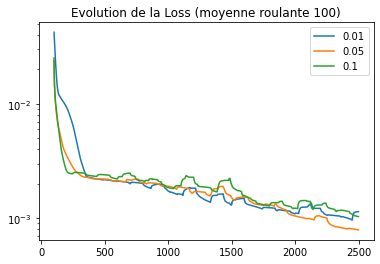

In [21]:
window_size = 100
num_epochs = 2500
lr_array = np.array([0.01,0.05,0.1])

for i in tqdm(range(len(lr_array))) :
  loss_list_series = pd.Series(np.repeat(0,num_epochs))
  for j in range(5): 
    lstm,loss_list = training_LSTM(trainX, trainY, num_epochs=num_epochs, learning_rate=lr_array[i], input_size=1, hidden_size=2, num_layers=1,num_classes=1, verbose=False)
    loss_list_series_temp = pd.Series(loss_list)
    loss_list_series = loss_list_series + loss_list_series_temp

  loss_list_series = loss_list_series/5
  loss_list_rolling = loss_list_series.rolling(window_size).mean()
  plt.plot(loss_list_rolling, label = str(lr_array[i]))

plt.yscale('log')
plt.title('Evolution de la Loss (moyenne roulante {})'.format(window_size))
plt.legend(loc=1)
plt.show()

Au regard du graphe précédent, il semble logique de privilégier 0.05 comme *learning rate*. 

### Prédictions du LSTM 

In [22]:
#Entrainement avec le learning rate selectionné 
lstm,loss_list = training_LSTM(trainX, trainY, learning_rate= 0.05)
lstm.eval()

#Calcul des prédictions 
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

Epoch: 0, loss: 0.04383
Epoch: 500, loss: 0.00197
Epoch: 1000, loss: 0.00076
Epoch: 1500, loss: 0.00068
Epoch: 2000, loss: 0.00066
Epoch: 2500, loss: 0.00081
Epoch: 3000, loss: 0.00064
Epoch: 3500, loss: 0.00080
Epoch: 4000, loss: 0.00064
Epoch: 4500, loss: 0.00063


In [23]:
#Stockage des valeurs prédites et réelles 
df2 = pd.DataFrame(dataY_plot[1:], columns = ['VALEUR'])
df2['forecast'] = data_predict[1:]
df2.index  = df.index

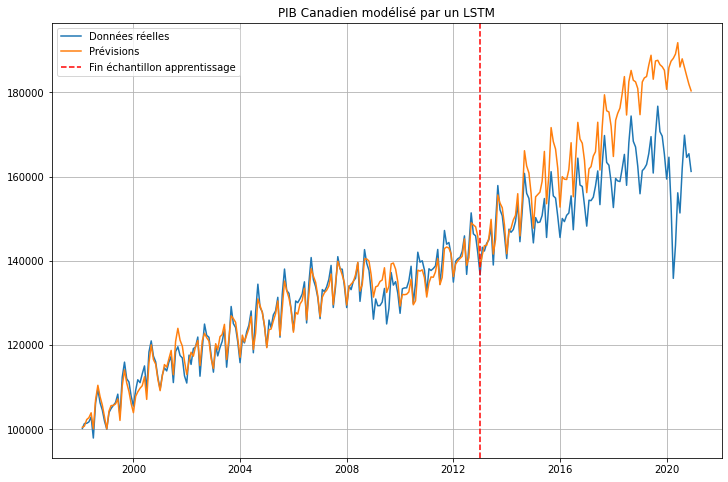

In [24]:
#Affichage des résultats
plt.figure(figsize=(12,8))
plt.plot(df2['VALEUR'], label = 'Données réelles')
plt.plot(df2['forecast'], label = 'Prévisions')
plt.axvline(x=date_end_train, c='r', linestyle='--', label = 'Fin échantillon apprentissage')
plt.grid()
plt.legend()
plt.title('PIB Canadien modélisé par un LSTM')
plt.show()

Le graphique ci-dessus nous prouve l'efficatité du LSTM pour la modélisation du GDP Canadien. Sur la partie Train les résultats semblent similaires au SARIMA.  Regardons les scores obtenus :  

In [41]:
df2["VALEUR"][date_begin_test : date_begin_test + relativedelta(years=2)]

PÉRIODE DE RÉFÉRENCE
2013-02-01    143231.0
2013-03-01    142351.0
2013-04-01    144160.0
2013-05-01    144980.0
2013-06-01    148069.0
2013-07-01    139028.0
2013-08-01    148887.0
2013-09-01    157886.0
2013-10-01    152131.0
2013-11-01    150708.0
2013-12-01    146073.0
2014-01-01    140565.0
2014-02-01    147530.0
2014-03-01    146796.0
2014-04-01    147441.0
2014-05-01    149362.0
2014-06-01    153643.0
2014-07-01    144558.0
2014-08-01    151824.0
2014-09-01    160773.0
2014-10-01    156049.0
2014-11-01    154832.0
2014-12-01    150260.0
2015-01-01    144278.0
2015-02-01    150286.0
Name: VALEUR, dtype: float32

In [42]:
#Test 
print("Test scores")
print("-----------") 
print('rmse : {:.2f}'.format(np.sqrt(mean_squared_error(df2["VALEUR"][date_begin_test:] , df2["forecast"][date_begin_test:] ))))
print('correlation : {:.2f}%'.format(np.corrcoef(df2["VALEUR"][date_begin_test:] , df2["forecast"][date_begin_test:])[0,1]*100))
print('r2 : {:.3f}'.format(r2_score(df2["VALEUR"][date_begin_test:], df2["forecast"][date_begin_test:])))
print('\n')
#Test à deux ans 
print("Test scores (à deux ans)")
print("-------------------------") 
print('rmse : {:.2f}'.format(np.sqrt(mean_squared_error(df2["VALEUR"][date_begin_test : date_begin_test + relativedelta(years=2)] , df2["forecast"][date_begin_test : date_begin_test + relativedelta(years=2)] ))))
print('correlation : {:.2f}%'.format(np.corrcoef(df2["VALEUR"][date_begin_test : date_begin_test + relativedelta(years=2):], df2["forecast"][date_begin_test : date_begin_test + relativedelta(years=2)])[0,1]*100))
print('r2 : {:.3f}'.format(r2_score(df2["VALEUR"][date_begin_test : date_begin_test + relativedelta(years=2)], df2["forecast"][date_begin_test : date_begin_test + relativedelta(years=2)])))
print('\n')
#Train  
print("Train scores")
print("------------") 
print('rmse : {:.2f}'.format(np.sqrt(mean_squared_error(df2["VALEUR"][:date_end_train], df2["forecast"][:date_end_train]))))
print('correlation : {:.2f}%'.format(np.corrcoef(df2["VALEUR"][:date_end_train], df2["forecast"][:date_end_train])[0,1]*100))
print('r2 : {:.3f}'.format(r2_score(df2["VALEUR"][:date_end_train], df2["forecast"][:date_end_train])))
print('\n')
#Train + Test 
print("Train + Test scores")
print("-------------------") 
print('rmse : {:.2f}'.format(np.sqrt(mean_squared_error(df2["VALEUR"], df2["forecast"]))))
print('correlation : {:.2f}%'.format(np.corrcoef(df2["VALEUR"], df2["forecast"])[0,1]*100))
print('r2 : {:.3f}'.format(r2_score(df2["VALEUR"], df2["forecast"])))
print('\n')

Test scores
-----------
rmse : 15239.67
correlation : 77.03%
r2 : -2.264


Test scores (à deux ans)
-------------------------
rmse : 3145.06
correlation : 93.33%
r2 : 0.643


Train scores
------------
rmse : 2139.56
correlation : 98.44%
r2 : 0.969


Train + Test scores
-------------------
rmse : 9122.90
correlation : 96.05%
r2 : 0.747




## Un modèle de *Convolutional Neural Network*(CNN) :

Les réseaux de neurones convolutifs (Convolutional Neural Networks en anglais). Ce type de réseaux de neurones est particulièrement adapté pour la classification ou traitement d'images mais il peut également être utilisé pour faire de la prédiction de séries temporelles comme nous allons le voir ici. 

### Chargement et transformation des données 

Comme précédemment nous récupérons les données initiales et nous les pré-traitons. Nous commençons par les normaliser et nous préparons de sorte que si l'on part d'une série : 

$s = [10, 20, 30, 40, 50, 60, 70, 80, 90]$

on la transforme en : 
$X = \begin{bmatrix}
10 & 20 & 30\\
20 & 30 & 40\\
30 & 40 & 50 \\
\cdots & \cdots & \cdots
\end{bmatrix}$ et $y=\begin{bmatrix}
40\\
50\\
60\\
\cdots
\end{bmatrix}$

Dans l'exemple précédent on a pris comme retard 3 mais nous prenons 12 par la suite pour s'adapter au problème. 

In [26]:
training_set = gdp_canada[["PÉRIODE DE RÉFÉRENCE", "VALEUR"]]
training_set = training_set.set_index('PÉRIODE DE RÉFÉRENCE')

In [27]:
#Normalisation 
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

training_set.VALEUR = training_data

#Separation train/valid
train_set = training_set[:'2013-01']
valid_set =  training_set['2013-02':]
print('Proportion of train_set : {:.2f}%'.format(len(train_set)/len(training_set)))
print('Proportion of valid_set : {:.2f}%'.format(len(valid_set)/len(training_set)))

Proportion of train_set : 0.67%
Proportion of valid_set : 0.33%


In [28]:
def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        
        end_ix = i + n_steps
        
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

n_steps = 12
train_x,train_y = split_sequence(train_set.VALEUR.values,n_steps)
valid_x,valid_y = split_sequence(valid_set.VALEUR.values,n_steps)

In [29]:
class GDPDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label

### Modélisation du CNN 

Ci-dessous nous détaillons l'architecture du réseau de neurones. Notons que l'on a opté pour la simplicité avec 3 neuronnes cachés : 1 neurone convolutif et deux neurones linéaires. 

In [30]:
class CNN_ForecastNet(nn.Module):
    def __init__(self,n_steps, batch_size):
        super(CNN_ForecastNet,self).__init__()
        self.conv1d = nn.Conv1d(n_steps,64,kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(64*batch_size,50)
        self.fc2 = nn.Linear(50,1)
        
    def forward(self,x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.view(-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

### Entrainement du modèle 

La fonction ci-dessous permet d'entrainer le CNN créé sur les données et de retourner le réseau ainsi que la perte lors de l'entrainement du modèle. 

In [31]:
def training_CNN(train_x, train_y, n_steps, batch_size, epochs=200, learning_rate =1e-5, verbose = True): 
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model = CNN_ForecastNet(n_steps,batch_size).to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  criterion = nn.MSELoss()

  train = GDPDataset(train_x.reshape(train_x.shape[0],train_x.shape[1],1),train_y)
  train_loader = torch.utils.data.DataLoader(train,batch_size=batch_size,shuffle=False, drop_last = True)
  train_losses = []

  for epoch in range(epochs):
    
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
        preds = model(inputs.float())
        loss = criterion(preds,labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().numpy())
    
    if (verbose==True) & (epoch % 10 == 0):
        print("Epoch: %d, loss: %1.5f" % (epoch, train_loss))

    gc.collect()

  return model, train_losses

### Choix du *learning rate*

Comme dans la section précédente, nous choisissons le meilleur *learning rate* pour la descente de gradient. 

100%|██████████| 3/3 [14:07<00:00, 282.40s/it]


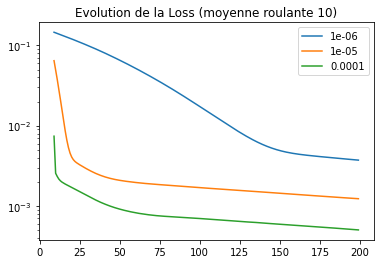

In [32]:
window_size = 10
num_epochs = 200
lr_array = np.array([1e-6,1e-5,1e-4])

for i in tqdm(range(len(lr_array))) :
  loss_list_series = pd.Series(np.repeat(0,num_epochs))
  for j in range(5): 
    cnn, loss_list = training_CNN(train_x, train_y, n_steps, batch_size=1, epochs=num_epochs, learning_rate =lr_array[i], verbose=False)
    loss_list_series_temp = pd.Series(loss_list)
    loss_list_series = loss_list_series + loss_list_series_temp

  loss_list_series = loss_list_series/5
  loss_list_rolling = loss_list_series.rolling(window_size).mean()
  plt.plot(loss_list_rolling, label = str(lr_array[i]))

plt.yscale('log')
plt.title('Evolution de la Loss (moyenne roulante {})'.format(window_size))
plt.legend(loc=1)
plt.show()

Ici, il semble que le *leaning rate* valant $10^{-4}$ est la meilleure option.

### Prédictions du CNN

Dans cette partie, on entraine le réseau sur les données sur l'échantillon *train* et avec le *learning rate* selectionné ci-dessus. Ensuite on réalise des prédictions à partir de  ce CNN. 

In [33]:
cnn, train_losses = training_CNN(train_x, train_y, n_steps, batch_size=1, epochs=200, learning_rate =1e-4, verbose=True)

Epoch: 0, loss: 0.01907
Epoch: 10, loss: 0.00225
Epoch: 20, loss: 0.00196
Epoch: 30, loss: 0.00166
Epoch: 40, loss: 0.00142
Epoch: 50, loss: 0.00122
Epoch: 60, loss: 0.00105
Epoch: 70, loss: 0.00093
Epoch: 80, loss: 0.00083
Epoch: 90, loss: 0.00077
Epoch: 100, loss: 0.00073
Epoch: 110, loss: 0.00068
Epoch: 120, loss: 0.00065
Epoch: 130, loss: 0.00062
Epoch: 140, loss: 0.00060
Epoch: 150, loss: 0.00057
Epoch: 160, loss: 0.00055
Epoch: 170, loss: 0.00053
Epoch: 180, loss: 0.00051
Epoch: 190, loss: 0.00049


In [34]:
#Evaluation du modèle 
target_x , target_y = split_sequence(training_set.VALEUR.values,n_steps)
inputs = target_x.reshape(target_x.shape[0],target_x.shape[1],1)

cnn.eval()
prediction = []
batch_size = 1
iterations =  int(inputs.shape[0]/batch_size)

for i in range(iterations):
    preds = cnn(torch.tensor(inputs[batch_size*i:batch_size*(i+1)]).float())
    prediction.append(preds.detach().numpy())

data_predict = sc.inverse_transform(prediction)
dataY_plot = sc.inverse_transform(target_y.reshape(-1,1))

In [35]:
#Stockage des valeurs prédites et réelles  
df3 = pd.DataFrame(dataY_plot[1:], columns = ['VALEUR'])
df3['forecast'] = data_predict[1:]
df3 = df3[:-1]
df3.index = df2.index 

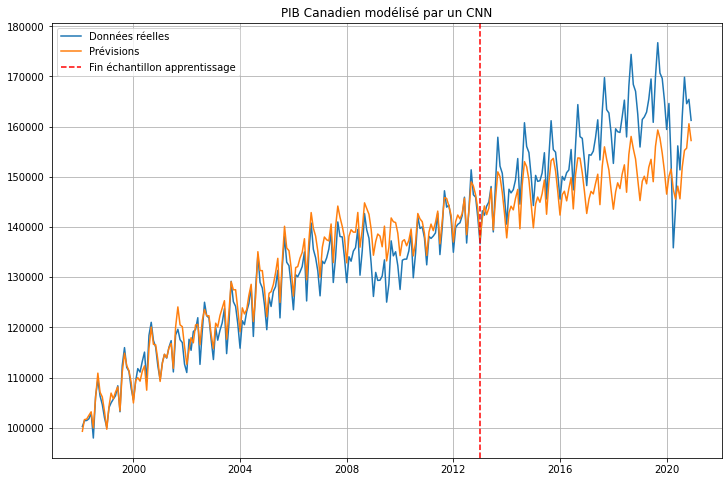

In [36]:
#Affichage des résultats
plt.figure(figsize=(12,8))
plt.plot(df3['VALEUR'], label = 'Données réelles')
plt.plot(df3['forecast'], label = 'Prévisions')
plt.axvline(x=date_end_train, c='r', linestyle='--', label = 'Fin échantillon apprentissage')
plt.grid()
plt.legend()
plt.title('PIB Canadien modélisé par un CNN')
plt.show()

Le CNN semble donner de bons résultats mais il est difficile de le comparer au LSTM. Regardons donc les scores afin de nous éclairer. 

In [44]:
#Test 
print("Test scores")
print("-----------") 
print('rmse : {:.2f}'.format(np.sqrt(mean_squared_error(df3["VALEUR"][date_begin_test:] , df3["forecast"][date_begin_test:] ))))
print('correlation : {:.2f}%'.format(np.corrcoef(df3["VALEUR"][date_begin_test:] , df3["forecast"][date_begin_test:])[0,1]*100))
print('r2 : {:.3f}'.format(r2_score(df3["VALEUR"][date_begin_test:], df3["forecast"][date_begin_test:])))
print('\n')
#Test à deux ans 
print("Test scores (à deux ans)")
print("-------------------------") 
print('rmse : {:.2f}'.format(np.sqrt(mean_squared_error(df3["VALEUR"][date_begin_test : date_begin_test + relativedelta(years=2)] , df3["forecast"][date_begin_test : date_begin_test + relativedelta(years=2)] ))))
print('correlation : {:.2f}%'.format(np.corrcoef(df3["VALEUR"][date_begin_test : date_begin_test + relativedelta(years=2)] , df3["forecast"][date_begin_test : date_begin_test + relativedelta(years=2)])[0,1]*100))
print('r2 : {:.3f}'.format(r2_score(df3["VALEUR"][date_begin_test : date_begin_test + relativedelta(years=2)], df3["forecast"][date_begin_test : date_begin_test + relativedelta(years=2)])))
print('\n')
#Train  
print("Train scores")
print("------------") 
print('rmse : {:.2f}'.format(np.sqrt(mean_squared_error(df3["VALEUR"][:date_end_train], df3["forecast"][:date_end_train]))))
print('correlation : {:.2f}%'.format(np.corrcoef(df3["VALEUR"][:date_end_train], df3["forecast"][:date_end_train])[0,1]*100))
print('r2 : {:.3f}'.format(r2_score(df3["VALEUR"][:date_end_train], df3["forecast"][:date_end_train])))
print('\n')
#Train + Test 
print("Train + Test scores")
print("-------------------") 
print('rmse : {:.2f}'.format(np.sqrt(mean_squared_error(df3["VALEUR"], df3["forecast"]))))
print('correlation : {:.2f}%'.format(np.corrcoef(df3["VALEUR"], df3["forecast"])[0,1]*100))
print('r2 : {:.3f}'.format(r2_score(df3["VALEUR"], df3["forecast"])))
print('\n')

Test scores
-----------
rmse : 8795.65
correlation : 86.70%
r2 : -0.087


Test scores (à deux ans)
-------------------------
rmse : 4125.75
correlation : 92.21%
r2 : 0.385


Train scores
------------
rmse : 3046.96
correlation : 98.58%
r2 : 0.937


Train + Test scores
-------------------
rmse : 5727.33
correlation : 96.23%
r2 : 0.900




## Conclusion

Une analyse plus détaillée des résultats ainsi qu'une conclusion à ce projet est disponible dans le rapport disponible sur le dépôt [GitLab](https://gitlab.com/JACQUOT_THOMAS/gdp_canada_lstm). 